In [10]:
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import torch
import torch.nn as nn

import os
import sys  

from utils import *

%matplotlib inline

ImportError: cannot import name 'remove_dataparallel_wrapper' from 'utils' (/Users/qiao/Documents/IAV_Processing/Project/BFDnCNN/bias_free_denoising-master/utils/__init__.py)

In [66]:
pip uninstall torch --yes

Found existing installation: torch 1.8.1
Uninstalling torch-1.8.1:
  Successfully uninstalled torch-1.8.1
Note: you may need to restart the kernel to use updated packages.


In [67]:
pip install torch==1.8.1 -f https://download.pytorch.org/whl/torch_stable.html

distutils: /Library/Frameworks/Python.framework/Versions/3.8/include/python3.8/UNKNOWN
sysconfig: /Library/Frameworks/Python.framework/Versions/3.8/include/python3.8
user = False
home = None
root = None
prefix = None
Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached torch-1.8.1-cp38-none-macosx_10_9_x86_64.whl (119.6 MB)
distutils: /Library/Frameworks/Python.framework/Versions/3.8/include/python3.8/UNKNOWN
sysconfig: /Library/Frameworks/Python.framework/Versions/3.8/include/python3.8
user = False
home = None
root = None
prefix = None
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# Removing bias enables generalization

In this notebook, we examine generalization of denoising performance to noise levels beyond those used during training.  We compare generalization capabilities of a given model (e.g. DnCNN), and its bias free version (e.g. BF_DnCNN).  We show that performance of the two models is similar within the training range, but that the bias-free network is substantially better outside the training range.


In [3]:
# Paths for data, pretrained models, and precomputed performance measures
pretrained_base = './pretrained/'
precomputed_base = './precomputed/'
data_base = 'data/'

# Datasets available in the data folder
train_folder_path = os.path.join(data_base, 'Train400/')
test_folder_path = os.path.join(data_base, 'Test/Set68/')
set12_path = os.path.join(data_base, 'Test/Set12/')
kodak_path = os.path.join(data_base, 'Test/Kodak23/') 

### Choose a model 

Both the original model, and its bias-free counterpart, will be loaded. You can train and use any other model using the train script provided in the repository. 

In [4]:
# Choose a model to load (options are: 'dncnn', 'unet', 'rcnn', 'sdensenet')
model = 'dncnn' 

# Select the range of training noise levels (stdev, relative to intensity range [0,255]). 
# Pre-computed options are 0-10, 0-30, 0-55, 0-100.
min_noise = 0   # lower bound of training range 
max_noise = 10  # upper bound of training range 

### Display a randomly selected set of 4 noisy images used during training of this model 


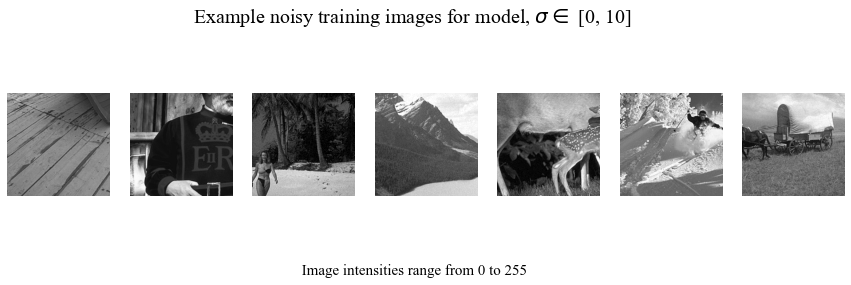

In [5]:
f, axs = plt.subplots(1,7, figsize = (15,4), squeeze=True)
f.suptitle(r'Example noisy training images for model, $\sigma \in$ [' + str(min_noise) +', '+ str(max_noise) +']',  fontname= 'Times New Roman', fontsize = 20)
f.text(.5, .05, ' Image intensities range from 0 to 255',ha='center',  fontname= 'Times New Roman', fontsize = 15)
for i in range(7): 
    tr_im_n = np.random.randint(0,len(os.listdir(train_folder_path)))
    tr_im = single_image_loader(train_folder_path, tr_im_n)
    tr_dim1, tr_dim2 = tr_im.shape
    tr_noisy, _ = add_noise2(tr_im.reshape(1,tr_dim1,tr_dim2), [min_noise,max_noise], 'B') 
    tr_noisy = tr_noisy.reshape(tr_dim1,tr_dim2)
    axs[i].imshow(tr_noisy, 'gray', vmin= 0, vmax = 1)
    axs[i].axis('off');
    
tr_im_n = 6
tr_im = single_image_loader(train_folder_path, tr_im_n)
tr_dim1, tr_dim2 = tr_im.shape
tr_noisy, _ = add_noise2(tr_im.reshape(1,tr_dim1,tr_dim2), [80, 90], 'B') 
tr_noisy = tr_noisy.reshape(tr_dim1,tr_dim2)
matplotlib.image.imsave('ori_bird.png', tr_im, cmap="gray")
matplotlib.image.imsave('noisy_bird.png', tr_noisy, cmap="gray")

In [6]:
# Load pre-trained models
CNN = load_model(os.path.join(pretrained_base, model, 'bias', str(min_noise)+'-'+str(max_noise)+'.pt'))
BF_CNN = load_model(os.path.join(pretrained_base, model, 'bias_free', str(min_noise)+'-'+str(max_noise)+'.pt'))

In [21]:
class UpSampleFeatures(nn.Module):
    r"""Implements the last layer of FFDNet
    """
    def __init__(self):
        super(UpSampleFeatures, self).__init__()
    def forward(self, x):
        return functions.upsamplefeatures(x)

class IntermediateDnCNN(nn.Module):
    r"""Implements the middel part of the FFDNet architecture, which
    is basically a DnCNN net
    """
    def __init__(self, input_features, middle_features, num_conv_layers):
        super(IntermediateDnCNN, self).__init__()
        self.kernel_size = 3
        self.padding = 1
        self.input_features = input_features
        self.num_conv_layers = num_conv_layers
        self.middle_features = middle_features
        if self.input_features == 5:
            self.output_features = 4 #Grayscale image
        elif self.input_features == 15:
            self.output_features = 12 #RGB image
        else:
            raise Exception('Invalid number of input features')

        layers = []
        layers.append(nn.Conv2d(in_channels=self.input_features,\
                                out_channels=self.middle_features,\
                                kernel_size=self.kernel_size,\
                                padding=self.padding,\
                                bias=False))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(self.num_conv_layers-2):
            layers.append(nn.Conv2d(in_channels=self.middle_features,\
                                    out_channels=self.middle_features,\
                                    kernel_size=self.kernel_size,\
                                    padding=self.padding,\
                                    bias=False))
            layers.append(nn.BatchNorm2d(self.middle_features))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=self.middle_features,\
                                out_channels=self.output_features,\
                                kernel_size=self.kernel_size,\
                                padding=self.padding,\
                                bias=False))
        self.itermediate_dncnn = nn.Sequential(*layers)
    def forward(self, x):
        out = self.itermediate_dncnn(x)
        return out
class FFDNet(nn.Module):
    r"""Implements the FFDNet architecture
    """
    def __init__(self, num_input_channels):
        super(FFDNet, self).__init__()
        self.num_input_channels = num_input_channels
        if self.num_input_channels == 1:
            # Grayscale image
            self.num_feature_maps = 64
            self.num_conv_layers = 15
            self.downsampled_channels = 5
            self.output_features = 4
        elif self.num_input_channels == 3:
            # RGB image
            self.num_feature_maps = 96
            self.num_conv_layers = 12
            self.downsampled_channels = 15
            self.output_features = 12
        else:
            raise Exception('Invalid number of input features')

        self.intermediate_dncnn = IntermediateDnCNN(\
                input_features=self.downsampled_channels,\
                middle_features=self.num_feature_maps,\
                num_conv_layers=self.num_conv_layers)
        self.upsamplefeatures = UpSampleFeatures()

    def forward(self, x):
        concat_noise_x = concatenate_input_noise_map(\
                x.data, 90)
        concat_noise_x = Variable(concat_noise_x)
        h_dncnn = self.intermediate_dncnn(concat_noise_x)
        pred_noise = self.upsamplefeatures(h_dncnn)
        return pred_noise

In [22]:
def remove_dataparallel_wrapper(state_dict):
    r"""Converts a DataParallel model to a normal one by removing the "module."
    wrapper in the module dictionary

    Args:
        state_dict: a torch.nn.DataParallel state dictionary
    """
    from collections import OrderedDict

    new_state_dict = OrderedDict()
    for k, vl in state_dict.items():
        name = k[7:] # remove 'module.' of DataParallel
        new_state_dict[name] = vl

    return new_state_dict

In [2]:
print(torch.__version__)

1.8.1


In [23]:
model_fn = os.path.join(pretrained_base, model, 'bias','net.pth')
net = FFDNet(num_input_channels=1)
state_dict = torch.load(model_fn, map_location='cpu')
state_dict = remove_dataparallel_wrapper(state_dict)
model_ffd = net
model_ffd.load_state_dict(state_dict)
model_ffd.eval()

FFDNet(
  (intermediate_dncnn): IntermediateDnCNN(
    (itermediate_dncnn): Sequential(
      (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU(inplace=True)
      (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [17]:
from torch.autograd import Function, Variable

In [19]:
def concatenate_input_noise_map(input, noise_sigma):
    r"""Implements the first layer of FFDNet. This function returns a
    torch.autograd.Variable composed of the concatenation of the downsampled
    input image and the noise map. Each image of the batch of size CxHxW gets
    converted to an array of size 4*CxH/2xW/2. Each of the pixels of the
    non-overlapped 2x2 patches of the input image are placed in the new array
    along the first dimension.

    Args:
        input: batch containing CxHxW images
        noise_sigma: the value of the pixels of the CxH/2xW/2 noise map
    """
    # noise_sigma is a list of length batch_size
    N, C, H, W = input.size()
    dtype = input.type()
    sca = 2
    sca2 = sca*sca
    Cout = sca2*C
    Hout = H//sca
    Wout = W//sca
    idxL = [[0, 0], [0, 1], [1, 0], [1, 1]]

    # Fill the downsampled image with zeros
    if 'cuda' in dtype:
        downsampledfeatures = torch.cuda.FloatTensor(N, Cout, Hout, Wout).fill_(0)
    else:
        downsampledfeatures = torch.FloatTensor(N, Cout, Hout, Wout).fill_(0)

    # Build the CxH/2xW/2 noise map
    noise_map = noise_sigma.view(N, 1, 1, 1).repeat(1, C, Hout, Wout)

    # Populate output
    for idx in range(sca2):
        downsampledfeatures[:, idx:Cout:sca2, :, :] = \
            input[:, :, idxL[idx][0]::sca, idxL[idx][1]::sca]

    # concatenate de-interleaved mosaic with noise map
    return torch.cat((noise_map, downsampledfeatures), 1)

## 1. Performance comparison on a single image 

In [24]:
# Denoise a noisy image (specify image by image_num, noise stdev by noise_level)
display_denoising(model_ffd, BF_CNN, set12_path, l = min_noise, h = max_noise, model = model,
                  image_num = 6, noise_level = 90);


AttributeError: 'int' object has no attribute 'view'

## 2. Performance comparison over many images

The following plots show output quality as a function of input quality for the CNN and BF_CNN models. The vertical blue band indicates the training range.  Quality values are expressed using PSNR (left) and SSIM (right), and are pre-computed. If you want to re-compute these (for example, on another dataset, or for a new model), set USE_PRECOMPUTED_METRICS to False (note: this may be SLOW on a CPU). 


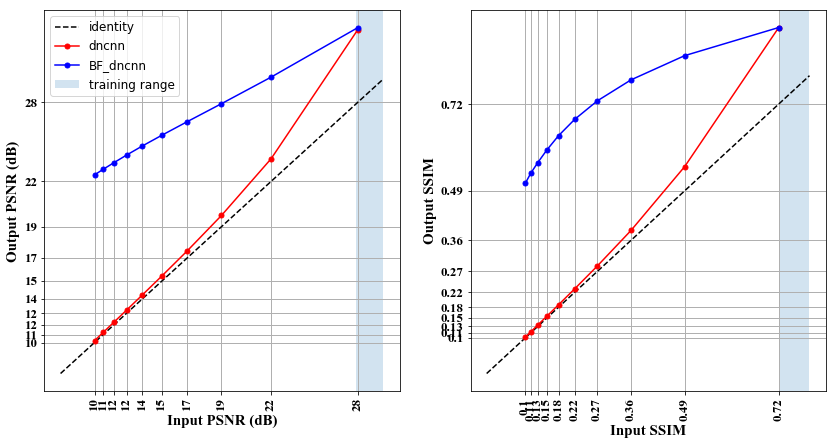

In [17]:
USE_PRECOMPUTED_METRICS = True

# specify model and training range [min_noise max_noise].  
compute_and_plot_performance_plot(model, min_noise, max_noise, pretrained_base,precomputed_base, USE_PRECOMPUTED_METRICS)
